# Recommender System - 기본 과제 \#2

## 개요

1. Neural Collaborative Filtering(NCF)을 PyTorch로 구현해본다.
2. AutoRec을 PyTorch로 구현해본다.


- 과제는 **<font color=#5F71F7>과제 HOMEWORK</font>** 라는 키워드로 표시하였습니다.
- <code><font color=#007979># FILL HERE : ... #</font></code>라고 쓰여 있는 부분을 채워넣으시면 됩니다.

---

## 0. 전처리

### 0.1. 기본 설정

In [ ]:
import numpy as np
import random
import pandas as pd
from datetime import datetime, date
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score
from tqdm import tqdm

import matplotlib.pyplot as plt
# import seaborn as sns
%matplotlib inline

# from IPython.display import Image

import torch
import torch.nn as nn
from torch.nn.init import normal_
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
###############################################################################
# 주어진 결과와 정확히 비교하기 위한 random seed 고정
###############################################################################

seed = 0  # 바꾸지 마시오!
random.seed(seed)
np.random.seed(seed)

### 0.2. MovieLens 데이터셋 불러오기


#### 활용 데이터셋 : MovieLens 100k Dataset

- 출처 :
    <br>Harper, F. M., & Konstan, J. A. (2015). **The MovieLens Datasets: History and Context.** ACM Transactions on Interactive Intelligent Systems (TIIS), 5(4), 1-19. http://dx.doi.org/10.1145/2827872
    
    
- 본 데이터셋은 직접 GroupLens 측을 통해 Naver Boostcamp RecSys 강좌 내에서 활용 및 재배포를 허가받은 데이터셋입니다.
    <br> 과제 외의 목적으로 이용하고자 할 경우 [원시 데이터](https://grouplens.org/datasets/movielens/)를 직접 다운받아 사용하시기 바랍니다.
    <br> ( 각 데이터셋에 대한 README.txt 파일을 통해 라이센스 정보를 확인하실 수 있습니다. )
    

- NCF 예제에서는 영화를 시청했는지 여부를 기록한 Implicit Feedback 데이터 사용합니다.

In [ ]:
import os
base_path = os.path.join(os.curdir, 'data/')
data_path = os.path.join(base_path, 'ml-100k/')

In [ ]:
# 평점 데이터
ratings_df = pd.read_csv(data_path + 'u.data', sep='\t', encoding='latin-1', header=None)
ratings_df.columns = ['user_id', 'movie_id', 'rating', 'timestamp']

### 0.3. MovieLens 데이터를 Implicit Feedback 데이터로 변환

In [ ]:
user_ids = ratings_df['user_id'].unique()
movie_ids = ratings_df['movie_id'].unique()

ratings_matrix = ratings_df.pivot(index='user_id', columns='movie_id', values='rating')

implicit_df = dict()
implicit_df['user_id'] = list()
implicit_df['movie_id'] = list()
implicit_df['implicit_feedback'] = list()
user_dict = dict()
movie_dict = dict()
for u, user_id in tqdm(enumerate(user_ids)):
    user_dict[u] = user_id
    for i, movie_id in enumerate(movie_ids):
        if i not in movie_dict:
            movie_dict[i] = movie_id
        implicit_df['user_id'].append(u)
        implicit_df['movie_id'].append(i)
        if pd.isna(ratings_matrix.loc[user_id, movie_id]):
            implicit_df['implicit_feedback'].append(0)
        else:
            implicit_df['implicit_feedback'].append(1)

In [ ]:
implicit_df = pd.DataFrame(implicit_df)

In [ ]:
implicit_df['user_id'] = implicit_df['user_id'].astype("category")
implicit_df['movie_id'] = implicit_df['movie_id'].astype("category")

### 0.4. NCF 모델에 사용할 데이터셋 만들기

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(
    implicit_df.loc[:, implicit_df.columns != 'implicit_feedback'], implicit_df['implicit_feedback'], test_size=0.2, random_state=seed,
    stratify=implicit_df['implicit_feedback']
)
print('학습 데이터 크기:', train_X.shape, train_y.shape)
print('테스트 데이터 크기:', test_X.shape, test_y.shape)

In [ ]:
# PyTorch의 DataLoader에서 사용할 수 있도록 변환 
train_dataset = TensorDataset(torch.LongTensor(np.array(train_X)), torch.FloatTensor(np.array(train_y)))
test_dataset = TensorDataset(torch.LongTensor(np.array(test_X)), torch.FloatTensor(np.array(test_y)))

## 1. PyTorch로 NCF Model 구현하기

In [ ]:
def activation_layer(activation_name='relu'):
    """
    Construct activation layers
    
    Args:
        activation_name: str, name of activation function
        emb_dim: int, used for Dice activation
    Return:
        activation: activation layer
    """
    if activation_name is None:
        activation = None
    elif isinstance(activation_name, str):
        if activation_name.lower() == 'sigmoid':
            activation = nn.Sigmoid()
        elif activation_name.lower() == 'tanh':
            activation = nn.Tanh()
        elif activation_name.lower() == 'relu':
            activation = nn.ReLU()
        elif activation_name.lower() == 'leakyrelu':
            activation = nn.LeakyReLU()
        elif activation_name.lower() == 'none':
            activation = None
    elif issubclass(activation_name, nn.Module):
        activation = activation_name()
    else:
        raise NotImplementedError("activation function {} is not implemented".format(activation_name))

    return activation

### <font color='#5F71F7'>과제 HOMEWORK (1)</font> 
### 1.1. `MLPLayers` 클래스 구현하기
- 'MLPLayers'에서 구현할 부분 : 각 Layer의 input size와 output size 정의

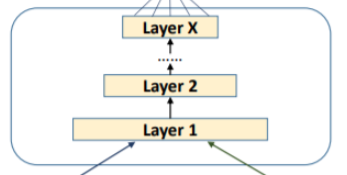

In [ ]:
class MLPLayers(nn.Module):
    """
    여러 층의 MLP Layer Class
    
    Args:
        - layers: (List) input layer, hidden layer, output layer의 node 수를 저장한 List.
                ex) [5, 4, 3, 2] -> input layer: 5 nodes, output layer: 2 nodes, hidden layers: 4 nodes, 3 nodes
        - dropout: (float) dropout 확률
        - activation: (str) activation function의 함수. Default: 'relu'
    Shape:
        - Input: (torch.Tensor) input features. Shape: (batch size, # of input nodes)
        - Output: (torch.Tensor) output features. Shape: (batch size, # of output nodes)
    """
    def __init__(self, layers, dropout, activation='relu'):
        super(MLPLayers, self).__init__()
        
        # initialize Class attributes
        self.layers = layers
        self.n_layers = len(self.layers) - 1
        self.dropout = dropout
        self.activation = activation
        
        # define layers
        mlp_modules = list()
        for i in range(self.n_layers):
            mlp_modules.append(nn.Dropout(p=self.dropout))
            input_size =  # FILL HERE : USE self.layers #
            output_size =  # FILL HERE : USE self.layers #
            mlp_modules.append(nn.Linear(input_size, output_size))
            activation_function = activation_layer(self.activation)
            if activation_function is not None:
                mlp_modules.append(activation_function)

        self.mlp_layers = nn.Sequential(*mlp_modules)
        
        self.apply(self._init_weights)
        
    # initialize weights
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            normal_(module.weight.data, 0, 0.01)
            if module.bias is not None:
                module.bias.data.fill_(0.0)
    
    def forward(self, input_feature):
        return self.mlp_layers(input_feature)

### <font color='#5F71F7'>과제 HOMEWORK (2)</font> 
### 1.2. `MLPLayers`를 이용해 `NCF` 클래스 구현하기
- 'NCF'에서 구현할 부분 : User Embedding, Item Embedding, Neural CF Layers, Output Layer

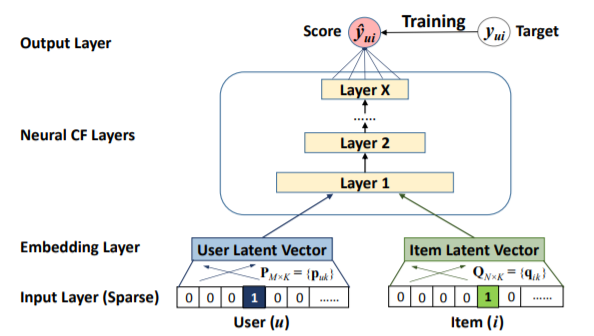

In [ ]:
class NCF(nn.Module):
    """
    Neural Collaborative Filtering
    
    Args:
        - n_users: (int) 전체 유저의 수
        - n_items: (int) 전체 아이템의 수
        - emb_dim: (int) Embedding의 Dimension
        - layers: (List) Neural CF Layers의 각 node 수를 저장한 List.
                ex) [5, 4, 3, 2] -> hidden layers: 5 nodes, 4 nodes, 3 nodes, 2 nodes
        - dropout: (float) dropout 확률
    Shape:
        - Input: (torch.Tensor) input features, (user_id, item_id). Shape: (batch size, 2)
        - Output: (torch.Tensor) expected implicit feedback. Shape: (batch size,)
    """
    def __init__(self, n_users, n_items, emb_dim, layers, dropout):
        super(NCF, self).__init__()
        
        # initialize Class attributes
        self.n_users = n_users
        self.n_items = n_items
        self.emb_dim = emb_dim
        self.layers = layers
        self.n_layers = len(self.layers) + 1
        self.dropout = dropout
        
        # define layers
        self.user_embedding =  # FILL HERE : USE nn.Embedding() #
        self.item_embedding =  # FILL HERE : USE nn.Embedding() #
        self.mlp_layers =  # FILL HERE : MLPLayers() #
        self.predict_layer =  # FILL HERE : USE nn.Linear() #
        self.sigmoid = nn.Sigmoid()
        
        self.apply(self._init_weights)
        
    # initialize weights
    def _init_weights(self, module):
        if isinstance(module, nn.Embedding):
            normal_(module.weight.data, mean=0.0, std=0.01)
        elif isinstance(module, nn.Linear):
            normal_(module.weight.data, 0, 0.01)
            if module.bias is not None:
                module.bias.data.fill_(0.0)
    
    def forward(self, input_feature):
        user, item = torch.split(input_feature, [1, 1], -1)
        user = user.squeeze(-1)
        item = item.squeeze(-1)
        
        user_e =  # FILL HERE : USE self.user_embedding() #
        item_e =  # FILL HERE : USE self.item_embedding() #
        
        input_feature =  # FILL HERE : USE torch.cat() #
        mlp_output =  # FILL HERE : USE self.mlp_layers() #
        output =  # FILL HERE : USE self.predict_layer() #
        output = self.sigmoid(output)
        return output.squeeze(-1)
    
    

### 1.3. NCF 모델 학습하기

- 학습 : Loss Function로 사용
- 검증 : Error Function 사용


#### 1.3.1. 학습 및 테스트에 필요한 함수 작성

In [ ]:
# Reference - https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if (batch+1) % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Loss: {loss:>7f} | [{current:>5d}/{size:>5d}]")
    train_loss /= num_batches
    
    return train_loss


def test_loop(dataloader, model, loss_fn, err_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss= 0
    test_err = 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            if err_fn is not None:
                test_err += err_fn(pred, y).item()
    test_loss /= num_batches
    test_err /= num_batches
    if err_fn is not None:
        print(f"Test Error:\n\tAvg Loss: {test_loss:>8f}\n\tError: {(test_err):>8f}")
    else:
        print(f"Test Error:\n\tAvg Loss: {test_loss:>8f}")
    return test_loss, test_err


In [ ]:
def train_and_test(train_dataloader, test_dataloader, model, loss_fn, err_fn, optimizer, epochs):
    train_loss, test_loss, test_err = list(), list(), list()

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_result= train_loop(train_dataloader, model, loss_fn, optimizer)
        train_loss.append(train_result)
        test_result = test_loop(test_dataloader, model, loss_fn, err_fn)
        test_loss.append(test_result[0])
        test_err.append(test_result[1])
        print("-------------------------------\n")
    print("Done!")

    return train_loss, test_loss, test_err


In [ ]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
    
    def forward(self, pred, y):
        loss = nn.MSELoss()(pred, y)
        return torch.sqrt(loss)

#### 1.3.2. 하이퍼파라미터 설정 & 학습에 필요한 인스턴스 선언 및 초기화

In [ ]:
######## Hyperparameter ########

batch_size = 2048
data_shuffle = True
emb_dim = 512
layers = [256, 64]
dropout = 0
epochs = 20
learning_rate = 0.001
gpu_idx = 0

n_users = ratings_df['user_id'].nunique()
n_items = ratings_df['movie_id'].nunique()

################################
# torch.cuda.empty_cache() # if necessary
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

device = torch.device("cuda:{}".format(gpu_idx) if torch.cuda.is_available() else "cpu")

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=data_shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=data_shuffle)

model = NCF(n_users, n_items, emb_dim, layers, dropout).to(device)

loss_fn = nn.BCELoss().to(device)
err_fn = None
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)

#### 1.3.3. 학습 진행

In [ ]:
train_loss, test_loss, test_err = train_and_test(train_dataloader, test_dataloader, model, loss_fn, err_fn, optimizer, epochs)

#### 1.3.4. 학습 곡선 도식화
다음과 같이 나와야 함

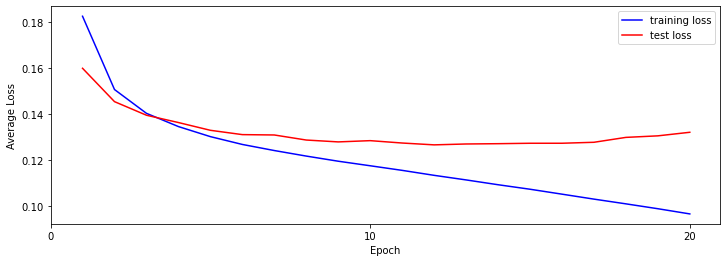

In [ ]:
fig, (loss_ax) = plt.subplots(1,1, figsize=(12,4))


loss_ax.plot(range(1,epochs+1), train_loss, 'b', label='training loss')
loss_ax.plot(range(1,epochs+1), test_loss, 'r', label='test loss')

loss_ax.set_xticks(range(0, epochs+1, 10))
loss_ax.set_xlabel('Epoch')
loss_ax.set_ylabel('Average Loss')
loss_ax.legend()

plt.show()

## 2. PyTorch로 AutoRec 구현하기

### <font color='#5F71F7'>과제 HOMEWORK (3)</font> 
### 2.1. `AutoRec` 구현하기
- `AutoRec`에서 구현할 부분 : Encoder, Decoder

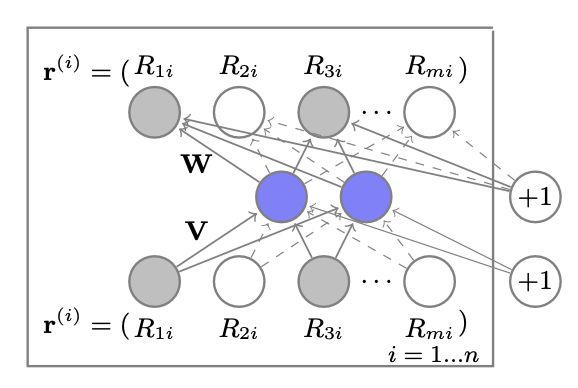

In [ ]:
class AutoRec(nn.Module):
    """
    AutoRec
    
    Args:
        - input_dim: (int) input feature의 Dimension
        - emb_dim: (int) Embedding의 Dimension
        - hidden_activation: (str) hidden layer의 activation function.
        - out_activation: (str) output layer의 activation function.
    Shape:
        - Input: (torch.Tensor) input features,. Shape: (batch size, input_dim)
        - Output: (torch.Tensor) reconstructed features. Shape: (batch size, input_dim)
    """
    def __init__(self, input_dim, emb_dim, hidden_activation, out_activation):
        super(AutoRec, self).__init__()
        
        # initialize Class attributes
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        
        # define layers
        self.encoder =  # FILL HERE : USE nn.Linear() #
        self.hidden_activation_function = activation_layer(hidden_activation)
        self.decoder =  # FILL HERE : USE nn.Linear() #
        self.out_activation_function = activation_layer(out_activation)
        
        self.apply(self._init_weights)
        
    # initialize weights
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            normal_(module.weight.data, 0, 0.01)
            if module.bias is not None:
                module.bias.data.fill_(0.0)
    
    def forward(self, input_feature):
        h =  # FILL HERE : USE self.encoder() #
        h = self.hidden_activation_function(h)
        
        output =  # FILL HERE : USE self.decoder() #
        output = self.out_activation_function(output)
        
        return output
    

### <font color='#5F71F7'>과제 HOMEWORK (4)</font> 
### 2.2. `AutoRec의 Loss Function` 구현하기
- `AutoRec의 Loss Function`에서 구현할 부분 : Observable한 데이터에 대해서만 더할 수 있도록 관측된 데이터의 index 구하기
- <font color=blue>참고 1)</font>
<br> MovieLens 데이터에서 rating은 1 ~ 5의 정수이다. 관측되지 않은 데이터의 경우, rating을 0으로 전처리하였다.

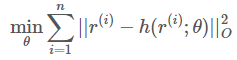

In [ ]:
class AutoRec_loss_fn(nn.Module):
    """
    AutoRec_loss_fn
    
    Args:
        - loss_fn: (nn.Module) 사용할 Loss Function
    Shape:
        - Input1: (torch.Tensor) Model의 예측 결과. Shape: (batch size,)
        - Input2: (torch.Tensor) 정답. Shape: (batch size,)
        - Output: (torch.Tensor) Observable한 데이터에 대해서만 계산한 Loss. Shape: ()
    """
    def __init__(self, loss_fn):
        super(AutoRec_loss_fn, self).__init__()
        self.loss_fn = loss_fn
    
    def forward(self, pred, y):
        y_for_compute = y.clone().to('cpu')
        index =  # FILL HERE : USE np.where & y_for_compute. WARNING: y를 사용 시, y의 device가 gpu일 경우 오류 발생 #
        loss = self.loss_fn(pred[index], y[index])
        return loss

### 2.3. MovieLens 데이터를 AutoRec 모델에 사용하기 위해 관측되지 않은 데이터를 0으로 전처리

In [ ]:
ratings_matrix = ratings_df.pivot(index='user_id', columns='movie_id', values='rating')
auto_rec_df = ratings_matrix.copy().fillna(0)

### 2.4. AutoRec 모델에 사용할 데이터셋 만들기

In [ ]:
train_rec_X, test_rec_X, train_rec_y, test_rec_y = train_test_split(
    auto_rec_df, auto_rec_df, test_size=0.2, random_state=seed,
)
print('학습 데이터 크기:', train_rec_X.shape, train_rec_y.shape)
print('테스트 데이터 크기:', test_rec_X.shape, test_rec_y.shape)

In [ ]:
assert np.sum(np.sum(train_rec_X != train_rec_y)) == 0

In [ ]:
# PyTorch의 DataLoader에서 사용할 수 있도록 변환 
train_rec_dataset = TensorDataset(torch.FloatTensor(np.array(train_rec_X)), torch.FloatTensor(np.array(train_rec_y)))
test_rec_dataset = TensorDataset(torch.FloatTensor(np.array(test_rec_X)), torch.FloatTensor(np.array(test_rec_y)))

### 2.5. AutoRec 모델 학습하기

In [ ]:
######## Hyperparameter ########

batch_size = 128
data_shuffle = True
input_dim = ratings_df['movie_id'].nunique()
emb_dim = 512
hidden_activation = 'relu'
out_activation = 'relu'
epochs = 30
learning_rate = 0.01
gpu_idx = 0

################################
# torch.cuda.empty_cache() # if necessary
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

device = torch.device("cuda:{}".format(gpu_idx) if torch.cuda.is_available() else "cpu")

train_rec_dataloader = DataLoader(train_rec_dataset, batch_size=batch_size, shuffle=data_shuffle)
test_rec_dataloader = DataLoader(test_rec_dataset, batch_size=batch_size, shuffle=data_shuffle)

model = AutoRec(input_dim, emb_dim, hidden_activation, out_activation).to(device)

loss_fn = AutoRec_loss_fn(nn.MSELoss().to(device)).to(device)
err_fn = AutoRec_loss_fn(nn.L1Loss().to(device)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)

In [ ]:
train_loss, test_loss, test_err = train_and_test(train_rec_dataloader, test_rec_dataloader, model, loss_fn, err_fn, optimizer, epochs)

#### 2.5.2. 학습 곡선 도식화
다음과 같이 나와야함

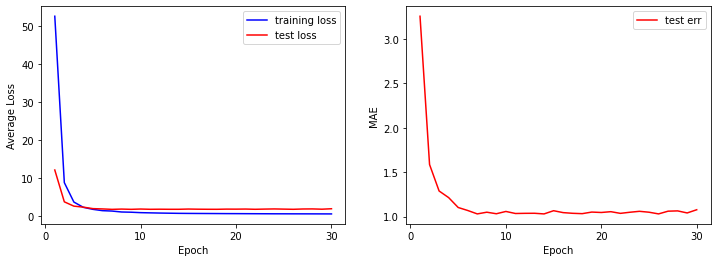

In [ ]:
fig, (loss_ax, err_ax) = plt.subplots(1,2, figsize=(12,4))

loss_ax.plot(range(1,epochs+1), train_loss, 'b', label='training loss')
loss_ax.plot(range(1,epochs+1), test_loss, 'r', label='test loss')
err_ax.plot(range(1,epochs+1), test_err, 'r', label='test err')

loss_ax.set_xticks(range(0, epochs+1, 10))
loss_ax.set_xlabel('Epoch')
loss_ax.set_ylabel('Average Loss')
loss_ax.legend()

err_ax.set_xticks(range(0, epochs+1, 10))
err_ax.set_xlabel('Epoch')
err_ax.set_ylabel('MAE')
err_ax.legend()

plt.show()